In [1]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-08-08 12:50:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-08-08 12:50:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-08-08 12:50:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [2]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
!unzip jigsaw-toxic-comment-classification-challenge.zip

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: test_labels.csv         
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [0]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from keras.models import Model
from keras.layers import (Dense,Embedding,Input,LSTM,Bidirectional,
                          GlobalMaxPooling1D,Dropout)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [9]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('glove.6B.%sd.txt'%EMBEDDING_DIM) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype='float32')
    word2vec[word] = vec
  print('Found %s word vectors.'%len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [10]:
# prepare text samples and their labels
print('Loading in comments...')
train = pd.read_csv('train.csv')
sentences = train['comment_text'].values
possible_labels = ['toxic','severe_toxic','obscene',
                   'threat','insult','identity_hate']
targets = train[possible_labels].values

Loading in comments...


In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [12]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.'%len(word2idx))

Found 210337 unique tokens.


In [13]:
# pad sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:',data.shape)

Shape of data tensor: (159571, 100)


In [14]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [0]:
# loading pre-trained word embeddings into an Embedding Layer
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
print('Building the model...')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels),activation='sigmoid')(x)

In [0]:
model = Model(input_,output)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])

In [23]:
print('Training model..')
r = model.fit(data, targets, batch_size=BATCH_SIZE,
              epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Training model..
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 212s 2ms/step - loss: 0.0809 - acc: 0.9748 - val_loss: 0.0588 - val_acc: 0.9799
Epoch 2/10
127656/127656 [==============================] - 212s 2ms/step - loss: 0.0564 - acc: 0.9804 - val_loss: 0.0569 - val_acc: 0.9801
Epoch 3/10
127656/127656 [==============================] - 212s 2ms/step - loss: 0.0545 - acc: 0.9808 - val_loss: 0.0561 - val_acc: 0.9802
Epoch 4/10
127656/127656 [==============================] - 210s 2ms/step - loss: 0.0538 - acc: 0.9808 - val_loss: 0.0544 - val_acc: 0.9808
Epoch 5/10
127656/127656 [==============================] - 209s 2ms/step - loss: 0.0517 - acc: 0.9813 - val_loss: 0.0551 - val_acc: 0.9805
Epoch 6/10
127656/127656 [==============================] - 212s 2ms/step - loss: 0.0513 - acc: 0.9814 - val_loss: 0.0541 - val_acc: 0.9805
Epoch 7/10
127656/127656 [==============================] - 212s 2ms/step - loss: 0.0504 - a

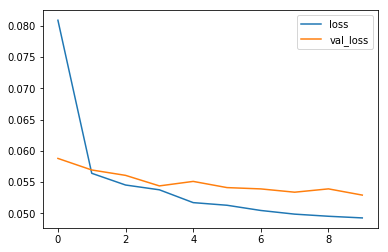

In [24]:
# plot the results
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

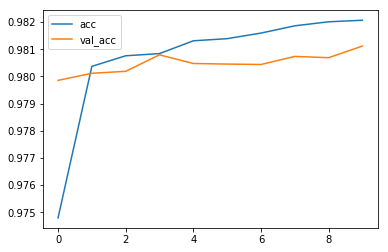

In [25]:
# accuracies
plt.plot(r.history['acc'],label='acc')
plt.plot(r.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

## Using Bidirectional LSTM

In [28]:
print('Building the model...')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
output = Dense(len(possible_labels),activation='sigmoid')(x)

Building the model...


In [0]:
model = Model(input_,output)
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])

In [30]:
print('Training model..')
r = model.fit(data, targets, batch_size=BATCH_SIZE,
              epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Training model..
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 464s 4ms/step - loss: 0.0677 - acc: 0.9775 - val_loss: 0.0550 - val_acc: 0.9807
Epoch 2/10
127656/127656 [==============================] - 459s 4ms/step - loss: 0.0525 - acc: 0.9812 - val_loss: 0.0527 - val_acc: 0.9809
Epoch 3/10
127656/127656 [==============================] - 464s 4ms/step - loss: 0.0499 - acc: 0.9819 - val_loss: 0.0518 - val_acc: 0.9813
Epoch 4/10
127656/127656 [==============================] - 462s 4ms/step - loss: 0.0487 - acc: 0.9822 - val_loss: 0.0517 - val_acc: 0.9813
Epoch 5/10
127656/127656 [==============================] - 456s 4ms/step - loss: 0.0478 - acc: 0.9826 - val_loss: 0.0512 - val_acc: 0.9813
Epoch 6/10
127656/127656 [==============================] - 456s 4ms/step - loss: 0.0471 - acc: 0.9826 - val_loss: 0.0503 - val_acc: 0.9818
Epoch 7/10
127656/127656 [==============================] - 459s 4ms/step - loss: 0.0464 - a

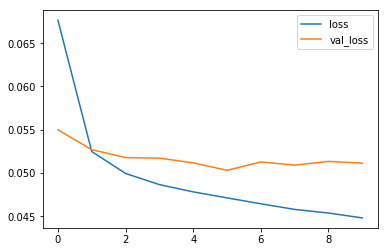

In [31]:
# plot the results
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

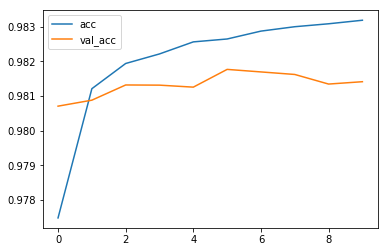

In [32]:
# accuracies
plt.plot(r.history['acc'],label='acc')
plt.plot(r.history['val_acc'],label='val_acc')
plt.legend()
plt.show()